## Does the loss go down?

### Mini-container:

In [1]:
### define utilities:
import numpy as np
import tensorflow as tf

np.random.seed(42)

def dual_opt(var_name_1, var_name_2, loss, optimizer):
    
    vars_1 = tf.get_collection(key = tf.GraphKeys.TRAINABLE_VARIABLES,
                                     scope= var_name_1)
    train_1 = optimizer.minimize(loss,var_list=vars_1)
        
    vars_2 = tf.get_collection(key = tf.GraphKeys.TRAINABLE_VARIABLES,
                                     scope = var_name_2)
    train_2 = optimizer.minimize(loss,var_list=vars_2)
    
    return tf.group(train_1, train_2)

def action_states(env,agent,actions):

    ss_ = np.concatenate((env.state_seq[env.iter-agent.horizon-1],env.state_seq[env.iter-1])).reshape((1,4))
    S = np.repeat(ss_,agent.horizon,axis=0)
            
    return np.concatenate((actions,S),axis=1)

### define environment:
class square_env:
    def __init__(self,duration,radius,dimension):
        if 2*radius > dimension:
            raise Warning("diameter can't exceed dimensions")
        self.R = radius # radius of agent
        self.dimension = dimension # LxW of the square world
        self.eps = radius/100
        self.iter = 0 # current iteration
        self.duration = duration # maximum duration of our environment
        self.state_seq = np.zeros((self.duration,2))
                
    def random_initialisation(self):
        # define the objective measure: 
        self.state_seq[self.iter][0] = np.random.uniform(self.R+self.eps,self.dimension-self.eps)
        self.state_seq[self.iter][1] = np.random.uniform(self.R+self.eps,self.dimension-self.eps)
        
        self.iter = 1
        
    def boundary_conditions(self):
        
        #boundary conditions:
        cond_X = (self.state_seq[self.iter-1][0] >= self.R+self.eps)*(self.state_seq[self.iter-1][0] <= self.dimension-self.R-self.eps)
        cond_Y = (self.state_seq[self.iter-1][1] >= self.R+self.eps)*(self.state_seq[self.iter-1][1] <= self.dimension-self.R-self.eps)

        return cond_X, cond_Y
        
    def step(self, action):
                
        self.state_seq[self.iter] = self.state_seq[self.iter-1] + action
        
        #boundary conditions:
        cond_X, cond_Y = self.boundary_conditions()
        
        #return to previous state if both conditions are not satisfied:
        if cond_X*cond_Y == 0:
            self.state_seq[self.iter] -= action
            
        self.iter += 1
            
        if self.iter > self.duration:
            raise Exception("Game over!")            
            
            
    def env_response(self,actions,horizon):
        # update the environment
        
        for i in range(1,horizon):
            self.step(actions[i])
        
        
    def reset(self):
        """
        Return to the initial conditions. 
        """
        self.state_seq = np.zeros((self.duration,2))
        self.iter = 0
        
        
### define agent:
import tensorflow_probability as tfp

class agent_cognition:
    
    """
        An agent that reasons using a measure of empowerment. 
        Here we assume that env refers to an initialised environment class. 
    """
    
    def __init__(self,planning_horizon,sess,seed, bound):
        self.sess = sess
        self.seed = seed
        self.horizon = planning_horizon        
        self.bound = bound
        
        self.current_state = tf.placeholder(tf.float32, [None, 2])
        self.source_action = tf.placeholder(tf.float32, [None, 2])
        
        self.source_input_n = tf.placeholder(tf.float32, [None, 4])
        self.decoder_input_n = tf.placeholder(tf.float32, [None, 6])
                        
        self.src_mu, self.src_log_sigma = self.source_dist_n()
        self.decoder_mu, self.decoder_log_sigma = self.decoder_dist_n()
    
    def init_weights(self,shape,var_name):
        """
            Xavier initialisation of neural networks
        """
        initializer = tf.contrib.layers.xavier_initializer()
        return tf.Variable(initializer(shape),name = var_name)
        
    def two_layer_net(self, X, w_h, w_h2, w_o,bias_1, bias_2):
        """
            A generic method for creating two-layer networks
            
            input: weights
            output: neural network
        """
        
        h = tf.nn.elu(tf.add(tf.matmul(X, w_h),bias_1))
        h2 = tf.nn.elu(tf.add(tf.matmul(h, w_h2),bias_2))
        
        return tf.matmul(h2, w_o)
    
    def empowerment_critic(self):
        """
        This function provides a cheap approximation to empowerment
        upon convergence of the training algorithm. Given that the 
        mutual information is non-negative this function must only
        give non-negative output. 
        
        input: state
        output: empowerment estimate
        """
        
        with tf.variable_scope("critic"):
            
            tf.set_random_seed(self.seed)
    
            w_h = self.init_weights([2,100],"w_h")
            w_h2 = self.init_weights([100,100],"w_h2")
            w_o = self.init_weights([100,1],"w_o")
            
            ### bias terms:
            bias_1 = self.init_weights([100],"bias_1")
            bias_2 = self.init_weights([100],"bias_2")
            bias_3 = self.init_weights([1],"bias_3")
                
            h = tf.nn.elu(tf.add(tf.matmul(self.current_state, w_h),bias_1))
            h2 = tf.nn.elu(tf.add(tf.matmul(h, w_h2),bias_2))
            
        return tf.nn.elu(tf.add(tf.matmul(h2, w_o),bias_3))
        
    def source_dist_n(self):
        
        """
            This is the per-action source distribution, also known as the 
            exploration distribution. 
        """
        
        with tf.variable_scope("source"):
            
            tf.set_random_seed(self.seed)
            
            W_h = self.init_weights([4,100],"W_h")
            W_h2 = self.init_weights([100,50],"W_h2")
            W_o = self.init_weights([50,10],"W_o")
            
            # define bias terms:
            bias_1 = self.init_weights([100],"bias_1")
            bias_2 = self.init_weights([50],"bias_2")
                        
            eta_net = self.two_layer_net(self.source_input_n,W_h, W_h2, W_o,bias_1,bias_2)
            
            W_mu = self.init_weights([10,2],"W_mu")
            W_sigma = self.init_weights([10,2],"W_sigma")
            
            mu = tf.multiply(tf.nn.tanh(tf.matmul(eta_net,W_mu)),self.bound)
            log_sigma = tf.multiply(tf.nn.tanh(tf.matmul(eta_net,W_sigma)),self.bound)
        
        return mu, log_sigma
    
    
    def sampler(self,mu,log_sigma):
                        
        return np.random.normal(mu,np.exp(log_sigma))   
    
    def random_actions(self):
        """
            This baseline is used to check that the source isn't completely useless. 
        """
        
        return np.random.normal(0,self.bound,size = (self.horizon,2))
        
    
    def source_actions(self,state):
        
        actions = np.zeros((self.horizon,2))
        
        ### add a zero action to the state:
        AS_0 = np.concatenate((np.zeros(2),state))
        
        mu, log_sigma = self.sess.run([self.src_mu,self.src_log_sigma], feed_dict={ self.source_input_n: AS_0.reshape((1,4))})
                                                
        for i in range(1,self.horizon):
                        
            AS_n = np.concatenate((actions[i-1],state))
            
            mu, log_sigma = self.sess.run([self.src_mu,self.src_log_sigma], feed_dict={ self.source_input_n: AS_n.reshape((1,4))})
                        
            actions[i] = self.sampler(mu, log_sigma)
                    
        return actions


    def source(self):

        mu, log_sigma = self.src_mu, self.src_log_sigma
            
        dist = tfp.distributions.MultivariateNormalDiag(mu, tf.exp(log_sigma))
                
        return tf.log(dist.prob(self.source_action)+tf.constant(1e-8))
        
    def decoder_dist_n(self): 
        
        """
            This is the per-action decoder, also known as the 
            planning distribution. 
        """
        
        with tf.variable_scope("decoder"):
            
            tf.set_random_seed(self.seed)
            
            W_h = self.init_weights([6,100],"W_h")
            W_h2 = self.init_weights([100,50],"W_h2")
            W_o = self.init_weights([50,10],"W_o")
            
            # define bias terms:
            bias_1 = self.init_weights([100],"bias_1")
            bias_2 = self.init_weights([50],"bias_2")
            
            eta_net = self.two_layer_net(self.decoder_input_n,W_h, W_h2, W_o,bias_1,bias_2)
            
            W_mu = self.init_weights([10,2],"W_mu")
            W_sigma = self.init_weights([10,2],"W_sigma")
            
            mu = tf.multiply(tf.nn.tanh(tf.matmul(eta_net,W_mu)),self.bound)
            log_sigma = tf.multiply(tf.nn.tanh(tf.matmul(eta_net,W_sigma)),self.bound)
            
        return mu, log_sigma
    
    
    def decoder(self):
        
        mu, log_sigma = self.decoder_mu, self.decoder_log_sigma
                
        dist = tfp.distributions.MultivariateNormalDiag(mu, tf.exp(log_sigma))
                
        return dist.log_prob(self.source_action)
    
    def decoder_actions(self,ss_):
        
        actions = np.zeros((self.horizon,2))
        
        ### add a zero action to the state:
        SS_0 = np.concatenate((np.zeros(2),ss_))
        
        mu, log_sigma = self.sess.run([self.decoder_mu,self.decoder_log_sigma], feed_dict={ self.decoder_input_n: SS_0.reshape((1,6))})
                                                
        for i in range(1,self.horizon):
                        
            SS_n = np.concatenate((actions[i-1],ss_))
    
            mu, log_sigma = self.sess.run([self.decoder_mu,self.decoder_log_sigma], feed_dict={ self.decoder_input_n: SS_n.reshape((1,6))})
                                
            actions[i] = self.sampler(mu, log_sigma)
                    
        return actions
    
    def mean_decoder_actions(self,ss_):
        
        actions, sigmas = np.zeros((self.horizon,2)), np.zeros((self.horizon,2))
        
        ### add a zero action to the state:
        SS_0 = np.concatenate((np.zeros(2),ss_))
        
        mu, log_sigma = self.sess.run([self.decoder_mu,self.decoder_log_sigma], feed_dict={ self.decoder_input_n: SS_0.reshape((1,6))})
                                                
        for i in range(1,self.horizon):
                        
            SS_n = np.concatenate((actions[i-1],ss_))
    
            mu, log_sigma = self.sess.run([self.decoder_mu,self.decoder_log_sigma], feed_dict={ self.decoder_input_n: SS_n.reshape((1,6))})
                                
            actions[i], sigmas[i] = mu, np.exp(log_sigma)
                    
        return actions, sigmas

### 1. Define experiment:

In [15]:
%matplotlib inline
## set random seed:
tf.set_random_seed(42)

def training(seed, batch_size, lr_1, lr_2, iters, horizon,bound):
    # define epoch counter:
    count = 0
    
    # define environment:
    env = square_env(duration=horizon,radius=0.5,dimension=2*(horizon-1.0))
        
    with tf.Session() as sess:
                
        A = agent_cognition(horizon,sess,seed,bound)   
            
        ### define the decoder, critic and source:
        log_decoder = A.decoder()
        E = A.empowerment_critic()
        log_source = A.source()
                
        # define a placeholder for beta values in the squared loss:
        beta =tf.placeholder(tf.float32, [None, 1])       
        
        ### it might be a good idea to regularise the squared loss:
        squared_loss = tf.reduce_mean(tf.square(beta*log_decoder-E-log_source))
        decoder_loss = tf.reduce_mean(tf.multiply(tf.constant(-1.0),log_decoder))
        
        ### define beta schedule:
        betas = 1./np.array([min(0.001 + i/iters,1) for i in range(iters)])
        
        ## define the inverse probability to learn from randomness: 
        N = min(iters,10000)
        
        inverse_prob = np.hstack((1./np.array([min(0.001 + i/N,1) for i in range(N)]),np.ones(iters-N)))
                
        ### define the optimiser:
        fast_optimizer = tf.train.AdagradOptimizer(lr_1)
        slow_optimizer = tf.train.AdagradOptimizer(lr_2)
        
        train_decoder = fast_optimizer.minimize(decoder_loss)
        
        ### define a dual optimizatio method for critic and source:
        train_critic_and_source = dual_opt("critic", "source", squared_loss, slow_optimizer)
        
        ### initialise the variables:
        sess.run(tf.global_variables_initializer())
        
        squared_losses, decoder_losses = np.zeros(iters), np.zeros(iters)
                        
        for count in range(iters):
            
            ## monitor the progress of training: 
            if count % 1000 == 0:
                print(count)
            
            ## reset the environment:
            env.reset()
            env.random_initialisation()
            
            mini_batch = np.zeros((batch_size*horizon,6))
            
            ### train our agent on a minibatch of recent experience:
            for i in range(batch_size):
                
                env.iter = 1
                                            
                if np.random.rand() > 1/inverse_prob[count]:
                    actions = A.random_actions()
                else:
                    actions = A.source_actions(env.state_seq[env.iter])
                        
                ## get responses from the environment:
                env.env_response(actions,A.horizon)
                                    
                ## group actions, initial state, and final state:                        
                axx_ = action_states(env,A,actions)
                
                mini_batch[horizon*i:horizon*(i+1)] = axx_
                
            train_feed_1 = {A.decoder_input_n : mini_batch,A.source_action : mini_batch[:,0:2]}
            sess.run(train_decoder,feed_dict = train_feed_1)
                
            # train source and critic:
            train_feed_2 = {beta: betas[count].reshape((1,1)), A.current_state: mini_batch[:,2:4],A.decoder_input_n : mini_batch, A.source_input_n : mini_batch[:,0:4], A.source_action : mini_batch[:,0:2]}
            sess.run(train_critic_and_source,feed_dict = train_feed_2)
                
            squared_losses[count] = sess.run(squared_loss,feed_dict = train_feed_2)
            decoder_losses[count] = sess.run(decoder_loss,feed_dict = train_feed_1)        
            
        return decoder_losses, squared_losses

### 2. Run first experiment:

In [3]:
horizon = 3
seed = [42,43]
bound = 1.0
iters = 10000 
batch_size = 50
num_expts = 2

lr_1, lr_2 = 0.01, 0.01

decoder_losses = np.zeros((num_expts,iters))
squared_losses = np.zeros((num_expts,iters))

for i in range(num_expts):
    decoder_losses[i], squared_losses[i] = training(seed[i], batch_size,lr_1, lr_2, iters, horizon,bound)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000


### 3.Visualizing the relationship:

<Figure size 1440x720 with 0 Axes>

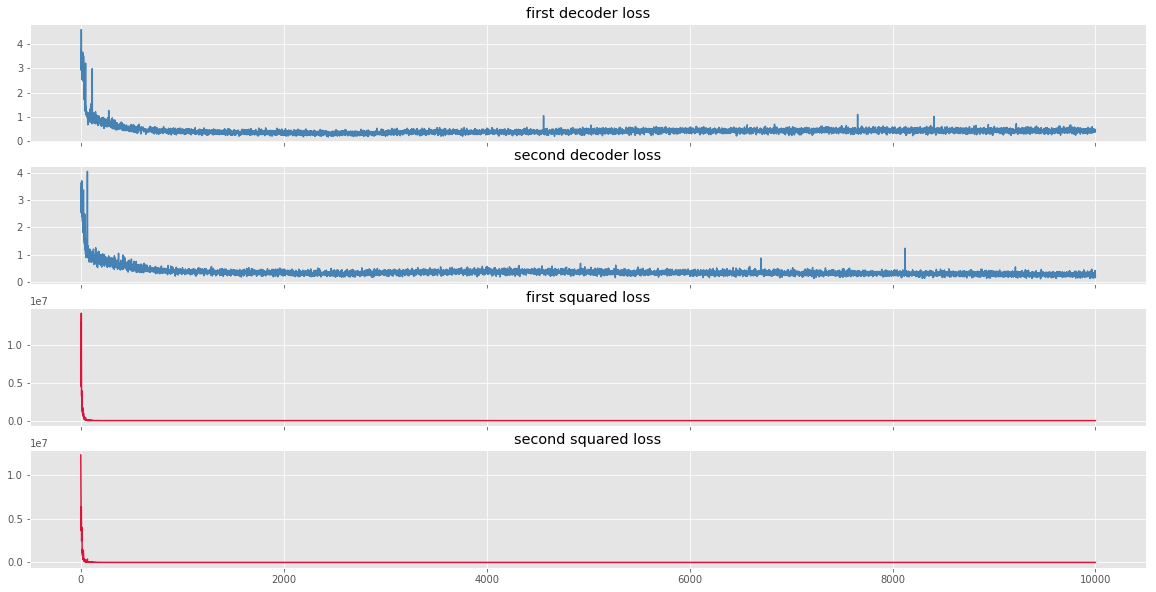

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20,10))
plt.style.use('ggplot')

f, axarr = plt.subplots(4, sharex=True,figsize=(20,10))
#plt.figure(figsize=(10,10))
axarr[0].set_title("first decoder loss")
axarr[0].plot(decoder_losses[0],'steelblue')

axarr[1].set_title("second decoder loss")
axarr[1].plot(decoder_losses[1],'steelblue')

axarr[2].set_title("first squared loss")
axarr[2].plot(squared_losses[0],'crimson')

axarr[3].set_title("second squared loss")
axarr[3].plot(squared_losses[1],'crimson')

plt.show()

### 4. Analysis of the loss curves: 

It appears that the loss goes to zero very quickly and then stabilizes. 

In [13]:
decoder_losses[0][10],decoder_losses[0][100],decoder_losses[0][1000],  decoder_losses[0][-1]

(3.2226874828338623,
 1.1366902589797974,
 0.3440439999103546,
 0.4728667736053467)

In [14]:
squared_losses[0][10],squared_losses[0][100],squared_losses[0][1000], squared_losses[0][-1]

(2709174.0, 23671.75390625, 154.95677185058594, 15.70047378540039)

It looks like the squared loss is still decreasing and that the decoder loss has basically decreased a lot faster than the squared loss. A reasonable next experiment would be to double
the number of iterations and see whether the squared loss approaches 0. I reckon that the reason why the decoder loss goes down more quickly is that it involves a maximum likelihood involving only one non-linear function.

### 5. Second experiment: 

In [21]:
horizon = 3
seed = [42,43]
bound = 1.0
iters = 20000 
batch_size = 50
num_expts = 2

lr_1, lr_2 = 0.01, 0.01

decoder_losses = np.zeros((num_expts,iters))
squared_losses = np.zeros((num_expts,iters))

for i in range(num_expts):
    decoder_losses[i], squared_losses[i] = training(seed[i], batch_size,lr_1, lr_2, iters, horizon,bound)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000


### 6. Visualize the loss curves: 

<Figure size 1440x720 with 0 Axes>

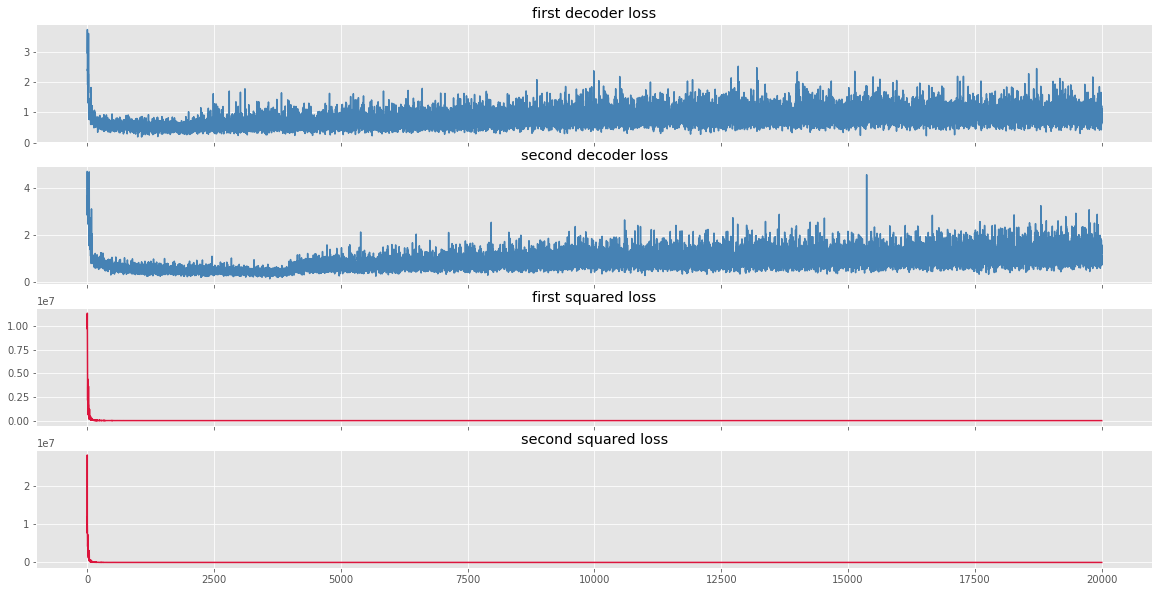

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20,10))
plt.style.use('ggplot')

f, axarr = plt.subplots(4, sharex=True,figsize=(20,10))
#plt.figure(figsize=(10,10))
axarr[0].set_title("first decoder loss")
axarr[0].plot(decoder_losses[0],'steelblue')

axarr[1].set_title("second decoder loss")
axarr[1].plot(decoder_losses[1],'steelblue')

axarr[2].set_title("first squared loss")
axarr[2].plot(squared_losses[0],'crimson')

axarr[3].set_title("second squared loss")
axarr[3].plot(squared_losses[1],'crimson')

plt.show()

### 7. Analysis of the loss curves: 

In [27]:
squared_losses[0][10],squared_losses[0][100],squared_losses[0][1000],squared_losses[0][10000], squared_losses[0][-1]

(3458874.25,
 77679.671875,
 549.0574951171875,
 17.985118865966797,
 15.929376602172852)

In [26]:
decoder_losses[1][10],decoder_losses[1][100],decoder_losses[1][1000],decoder_losses[0][10000],  decoder_losses[1][-1]

(3.055540084838867,
 1.1274242401123047,
 0.5968971848487854,
 0.789690375328064,
 1.198857069015503)